In [ ]:
!pip install -q transformers datasets scikit-learn matplotlib seaborn tensorflow torch accelerate

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [ ]:
nama_file = '/content/drive/MyDrive/Praktikum/UAP/Labeled.csv'

# Membaca dataset
df = pd.read_csv(nama_file, encoding='latin1')

# Menampilkan 5 baris pertama
print("📌 5 Data Teratas:")
display(df.head())

# Informasi umum tentang dataset
print("📌 Informasi Dataset:")
df.info()

# Statistik deskriptif
print("📌 Statistik Deskriptif:")
display(df.describe(include='all'))

# Jumlah nilai null per kolom
print("📌 Jumlah Nilai Kosong (Missing Values):")
display(df.isnull().sum())

# Bentuk (jumlah baris dan kolom)
print(f"📌 Dimensi Dataset: {df.shape[0]} baris dan {df.shape[1]} kolom\n")

# Tipe data setiap kolom
print("📌 Tipe Data Tiap Kolom:")
display(df.dtypes)

# Menampilkan nama kolom
print("📌 Nama-nama Kolom:")
display(df.columns.tolist())


📌 5 Data Teratas:


,Ulasan,Label
0,nerf algojo bro terlalu op gila lu minimal ner...,Negatif
1,"musuh sering beda level & game tiba"" lag banya...",Negatif
2,nostalgia dengan game terbaik,Positif
3,baik,Positif
4,game p2w,Negatif


📌 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ulasan  6001 non-null   object
 1   Label   6001 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB
📌 Statistik Deskriptif:


,Ulasan,Label
count,6001,6001
unique,5086,4
top,bagus,Negatif
freq,101,3324


📌 Jumlah Nilai Kosong (Missing Values):


,0
Ulasan,0
Label,0


📌 Dimensi Dataset: 6001 baris dan 2 kolom

📌 Tipe Data Tiap Kolom:


,0
Ulasan,object
Label,object


📌 Nama-nama Kolom:


['Ulasan', 'Label']

/tmp/ipython-input-1325952457.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Label', order=label_counts.index, palette='Set2')


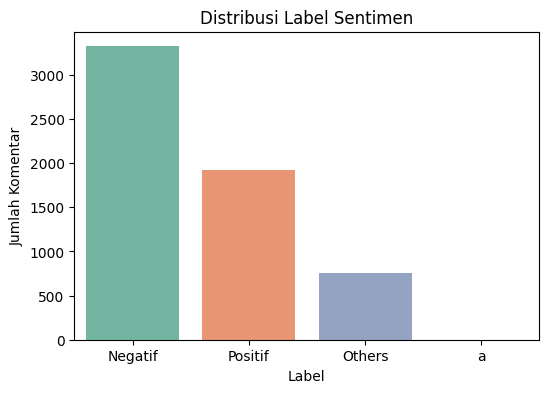

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung jumlah data per label
label_counts = df['Label'].value_counts()

# Plot distribusi label
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Label', order=label_counts.index, palette='Set2')
plt.title("Distribusi Label Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xlabel("Label")
plt.show()

In [ ]:
print(df['Label'].value_counts())
print(df['Label'].unique())

Label
Negatif    3324
Positif    1921
Others      755
a             1
Name: count, dtype: int64
['Negatif' 'Positif' 'Others' 'a']


In [ ]:
# Hapus data dengan label tidak valid
df = df[df['Label'].isin(['Negatif', 'Positif', 'Others'])]

# Reset index
df = df.reset_index(drop=True)

print(df['Label'].value_counts())

Label
Negatif    3324
Positif    1921
Others      755
Name: count, dtype: int64


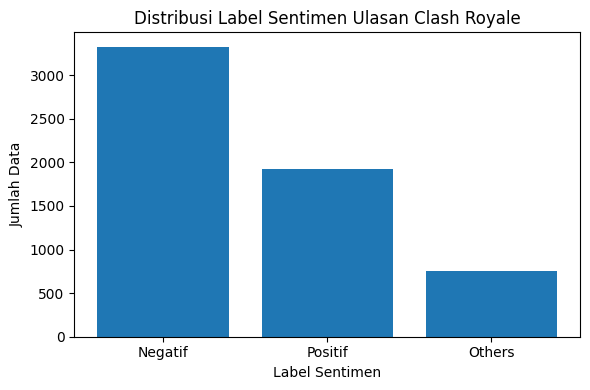

In [ ]:
label_counts = df['Label'].value_counts()

import numpy as np
import matplotlib.pyplot as plt

labels = label_counts.index.tolist()
values = label_counts.values
x = np.arange(len(labels))

plt.figure(figsize=(6,4))
plt.bar(x, values)
plt.xticks(x, labels)

plt.title("Distribusi Label Sentimen Ulasan Clash Royale")
plt.xlabel("Label Sentimen")
plt.ylabel("Jumlah Data")

plt.tight_layout()
plt.show()

In [ ]:
import os

base_path = "/content/drive/MyDrive/Praktikum/UAP"

os.makedirs(f"{base_path}/data", exist_ok=True)
os.makedirs(f"{base_path}/split", exist_ok=True)
os.makedirs(f"{base_path}/encoder", exist_ok=True)

print("✅ Folder Drive siap")

✅ Folder Drive siap


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

label_encoder = LabelEncoder()

df['label_encoded'] = label_encoder.fit_transform(df['Label'])

print("Mapping Label:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls} -> {i}")

Mapping Label:
Negatif -> 0
Others -> 1
Positif -> 2


In [ ]:
import joblib

encoder_path = f"{base_path}/encoder/label_encoder.pkl"
joblib.dump(label_encoder, encoder_path)

print(f"✅ LabelEncoder disimpan di: {encoder_path}")

✅ LabelEncoder disimpan di: /content/drive/MyDrive/Praktikum/UAP/encoder/label_encoder.pkl


In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)      # hapus URL
    text = re.sub(r"@\w+", "", text)         # hapus mention
    text = re.sub(r"#\w+", "", text)         # hapus hashtag
    text = re.sub(r"[^a-z\s]", " ", text)    # hapus simbol & angka
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df['clean_ulasan'] = df['Ulasan'].apply(clean_text)

df[['Ulasan', 'clean_ulasan']].head()

,Ulasan,clean_ulasan
0,nerf algojo bro terlalu op gila lu minimal ner...,nerf algojo bro terlalu op gila lu minimal ner...
1,"musuh sering beda level & game tiba"" lag banya...",musuh sering beda level game tiba lag banyak cit
2,nostalgia dengan game terbaik,nostalgia dengan game terbaik
3,baik,baik
4,game p2w,game p w


In [ ]:
# Pastikan kolom clean_ulasan bertipe string
df['clean_ulasan'] = df['clean_ulasan'].astype(str)

# Ganti 'nan' string hasil casting dengan kosong
df['clean_ulasan'] = df['clean_ulasan'].replace('nan', '')

In [ ]:
# Hapus ulasan kosong
df = df[df['clean_ulasan'].str.strip() != '']
df = df.reset_index(drop=True)

print("Sisa data:", df.shape[0])

Sisa data: 5942


In [ ]:
clean_data_path = f"{base_path}/data/dataset_cleaned.csv"
df.to_csv(clean_data_path, index=False)

print(f"✅ Dataset bersih disimpan di: {clean_data_path}")

✅ Dataset bersih disimpan di: /content/drive/MyDrive/Praktikum/UAP/data/dataset_cleaned.csv


In [ ]:
from sklearn.model_selection import train_test_split

X = df['clean_ulasan']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size: 4753
Test size : 1189


In [ ]:
X_train_path = f"{base_path}/split/X_train.csv"
X_test_path  = f"{base_path}/split/X_test.csv"
y_train_path = f"{base_path}/split/y_train.csv"
y_test_path  = f"{base_path}/split/y_test.csv"

X_train.to_csv(X_train_path, index=False)
X_test.to_csv(X_test_path, index=False)
y_train.to_csv(y_train_path, index=False)
y_test.to_csv(y_test_path, index=False)

print("✅ Data train-test berhasil disimpan ke Drive")

✅ Data train-test berhasil disimpan ke Drive


In [ ]:
import pandas as pd
import joblib

base_path = "/content/drive/MyDrive/Praktikum/UAP"

X_train = pd.read_csv(f"{base_path}/split/X_train.csv").iloc[:, 0]
X_test  = pd.read_csv(f"{base_path}/split/X_test.csv").iloc[:, 0]
y_train = pd.read_csv(f"{base_path}/split/y_train.csv").iloc[:, 0]
y_test  = pd.read_csv(f"{base_path}/split/y_test.csv").iloc[:, 0]

label_encoder = joblib.load(f"{base_path}/encoder/label_encoder.pkl")

print("✅ Data & encoder berhasil dimuat")

✅ Data & encoder berhasil dimuat


##LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

MAX_WORDS = 20000
MAX_LEN = 100

tokenizer_lstm = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(X_train)

X_train_seq = tokenizer_lstm.texts_to_sequences(X_train)
X_test_seq  = tokenizer_lstm.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

num_classes = len(label_encoder.classes_)

lstm_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(128),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class Weight:", class_weight_dict)

Class Weight: {0: np.float64(0.5967357187696171), 1: np.float64(2.6672278338945006), 2: np.float64(1.0534131205673758)}


In [ ]:
history_lstm = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2686 - loss: 1.0945 - val_accuracy: 0.3235 - val_loss: 1.1036
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2687 - loss: 1.0945 - val_accuracy: 0.3235 - val_loss: 1.1016
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2601 - loss: 1.0941 - val_accuracy: 0.3235 - val_loss: 1.1056
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2699 - loss: 1.0945 - val_accuracy: 0.3235 - val_loss: 1.1036
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2367 - loss: 1.0943 - val_accuracy: 0.1176 - val_loss: 1.1052
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2481 - loss: 1.0946 - val_accuracy: 0.1176 - val_loss: 1.1101
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2553 - loss: 1.0953 - val_accuracy: 0.1176 - val_loss: 1.1053
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2696 - loss: 1.0936 - val_accuracy: 0.3235 - v

In [ ]:
import os

os.makedirs(f"{base_path}/model", exist_ok=True)
model_path = f"{base_path}/model/lstm_model.keras"

lstm_model.save(model_path)

print(f"✅ Model LSTM disimpan di:\n{model_path}")

✅ Model LSTM disimpan di:
/content/drive/MyDrive/Praktikum/UAP/model/model/lstm_model.keras


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)

print("📊 Classification Report - LSTM")
print(classification_report(
    y_test,
    y_pred_lstm,
    target_names=label_encoder.classes_
))

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
📊 Classification Report - LSTM
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00       664
      Others       0.13      1.00      0.22       149
     Positif       0.00      0.00      0.00       376

    accuracy                           0.13      1189
   macro avg       0.04      0.33      0.07      1189
weighted avg       0.02      0.13      0.03      1189



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


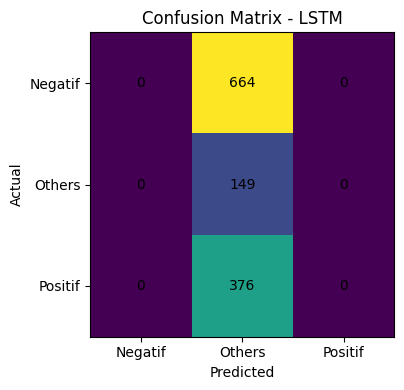

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_lstm)
labels = label_encoder.classes_
x = np.arange(len(labels))

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.xticks(x, labels)
plt.yticks(x, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

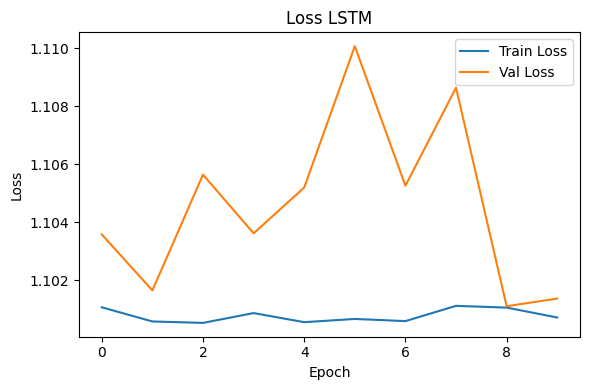

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title("Loss LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

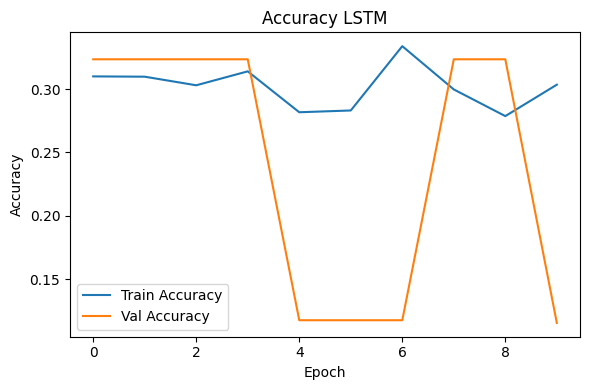

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

##IndoBERT

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device digunakan:", device)

Device digunakan: cuda


In [ ]:
import pandas as pd
import joblib

base_path = "/content/drive/MyDrive/Praktikum/UAP"

df = pd.read_csv(f"{base_path}/data/dataset_cleaned.csv")

X_train = pd.read_csv(f"{base_path}/split/X_train.csv").iloc[:, 0].astype(str)
X_test  = pd.read_csv(f"{base_path}/split/X_test.csv").iloc[:, 0].astype(str)
y_train = pd.read_csv(f"{base_path}/split/y_train.csv").iloc[:, 0].values
y_test  = pd.read_csv(f"{base_path}/split/y_test.csv").iloc[:, 0].values

label_encoder = joblib.load(f"{base_path}/encoder/label_encoder.pkl")

num_labels = len(label_encoder.classes_)
print("✅ Data siap untuk IndoBERT | Num labels:", num_labels)

✅ Data siap untuk IndoBERT | Num labels: 3


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

train_enc = tokenize_texts(X_train, tokenizer)
test_enc  = tokenize_texts(X_test, tokenizer)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_enc, y_train)
test_dataset  = TextDataset(test_enc, y_test)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=f"{base_path}/indobert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=f"{base_path}/logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    fp16=True,
    no_cuda=False,
    report_to="none"
)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-680341488.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.455883,0.838520,0.746019,0.744800,0.745356
2,0.237400,0.528217,0.835156,0.742257,0.742792,0.742332
3,0.237400,0.716716,0.839361,0.754349,0.749166,0.751027
4,0.140900,0.883776,0.832632,0.746270,0.754979,0.748938
5,0.140900,0.970935,0.835997,0.745449,0.742328,0.743856
6,0.068200,0.964244,0.847771,0.764449,0.762665,0.763294
7,0.040500,0.999129,0.841043,0.739609,0.725859,0.730457
8,0.040500,1.033293,0.835156,0.743372,0.742023,0.742660
9,0.030900,1.036335,0.841884,0.751896,0.744688,0.748098
10,0.030900,1.037878,0.842725,0.754200,0.745575,0.749606


TrainOutput(global_step=2980, training_loss=0.0906553934084489, metrics={'train_runtime': 614.7782, 'train_samples_per_second': 77.312, 'train_steps_per_second': 4.847, 'total_flos': 3102019833136140.0, 'train_loss': 0.0906553934084489, 'epoch': 10.0})

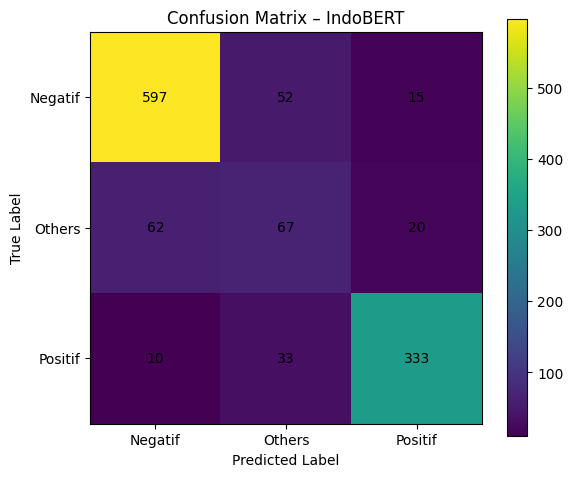

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Ambil prediksi
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_
x = np.arange(len(labels))

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.colorbar()

plt.xticks(x, labels)
plt.yticks(x, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.title("Confusion Matrix – IndoBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

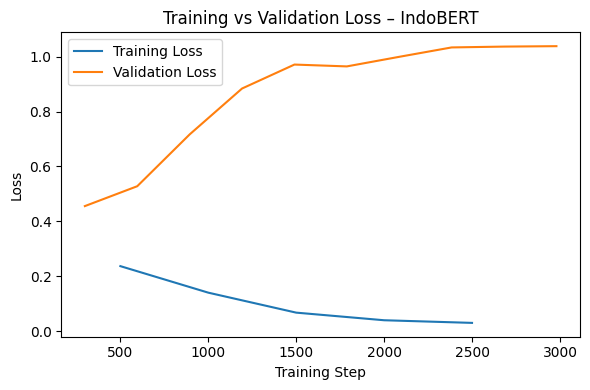

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_history = pd.DataFrame(trainer.state.log_history)

train_loss = log_history[log_history["loss"].notna()]
eval_loss  = log_history[log_history["eval_loss"].notna()]

plt.figure(figsize=(6,4))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")

plt.title("Training vs Validation Loss – IndoBERT")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

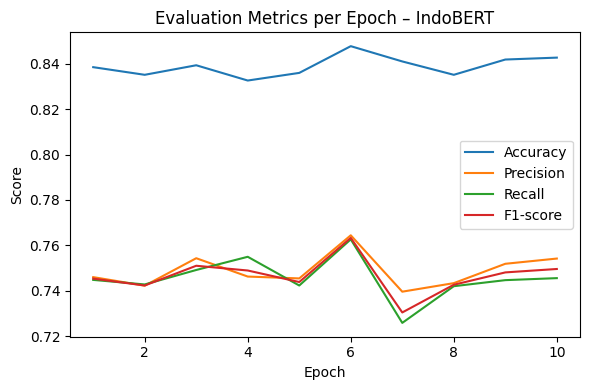

In [ ]:
eval_metrics = log_history[log_history["eval_accuracy"].notna()]

plt.figure(figsize=(6,4))
plt.plot(eval_metrics["epoch"], eval_metrics["eval_accuracy"], label="Accuracy")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_precision"], label="Precision")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_recall"], label="Recall")
plt.plot(eval_metrics["epoch"], eval_metrics["eval_f1"], label="F1-score")

plt.title("Evaluation Metrics per Epoch – IndoBERT")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os

base_path = "/content/drive/MyDrive/Praktikum/UAP/model"

# Buat folder kalau belum ada
os.makedirs(base_path, exist_ok=True)

# Path IndoBERT
indobert_path = f"{base_path}/indobert"

# Simpan model & tokenizer
trainer.model.save_pretrained(indobert_path)
trainer.tokenizer.save_pretrained(indobert_path)

print(f"✅ IndoBERT berhasil disimpan di:\n{indobert_path}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


✅ IndoBERT berhasil disimpan di:
/content/drive/MyDrive/Praktikum/UAP/model/indobert


##DistilBERT Indonesian

In [ ]:
import pandas as pd
import joblib

base_path = "/content/drive/MyDrive/Praktikum/UAP"

X_train = pd.read_csv(f"{base_path}/split/X_train.csv").iloc[:, 0].astype(str)
X_test  = pd.read_csv(f"{base_path}/split/X_test.csv").iloc[:, 0].astype(str)
y_train = pd.read_csv(f"{base_path}/split/y_train.csv").iloc[:, 0].values
y_test  = pd.read_csv(f"{base_path}/split/y_test.csv").iloc[:, 0].values

label_encoder = joblib.load(f"{base_path}/encoder/label_encoder.pkl")
num_labels = len(label_encoder.classes_)

print("✅ Data siap untuk IndoBERT Lite")

✅ Data siap untuk IndoBERT Lite


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

MODEL_NAME = "cahya/distilbert-base-indonesian"

tokenizer_lite = AutoTokenizer.from_pretrained(MODEL_NAME)
model_lite = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

model_lite.to(device)

Device: cuda


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/273M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at cahya/distilbert-base-indonesian and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def tokenize_texts(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

train_enc_lite = tokenize_texts(X_train, tokenizer_lite)
test_enc_lite  = tokenize_texts(X_test, tokenizer_lite)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_lite = TextDataset(train_enc_lite, y_train)
test_dataset_lite  = TextDataset(test_enc_lite, y_test)

In [ ]:
from transformers import TrainingArguments

training_args_lite = TrainingArguments(
    output_dir=f"{base_path}/distilbert_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=f"{base_path}/logs_distilbert",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1,
    fp16=True,
    no_cuda=False,
    report_to="none"
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    # Jika output model berupa tuple
    if isinstance(logits, tuple):
        logits = logits[0]

    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import Trainer

trainer_lite = Trainer(
    model=model_lite,
    args=training_args_lite,
    train_dataset=train_dataset_lite,
    eval_dataset=test_dataset_lite,
    tokenizer=tokenizer_lite,
    compute_metrics=compute_metrics
)

trainer_lite.train()

/tmp/ipython-input-3534315666.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lite = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.578661,0.816653,0.722551,0.724817,0.722709
2,No log,0.664318,0.817494,0.717528,0.715864,0.716547
3,No log,0.760623,0.798991,0.690658,0.699221,0.694294
4,0.123600,0.788129,0.812447,0.702007,0.705133,0.703433
5,0.123600,0.897366,0.817494,0.705509,0.697547,0.700736
6,0.123600,0.958811,0.814130,0.722852,0.727934,0.723953
7,0.056800,0.959637,0.821699,0.708374,0.702749,0.704850
8,0.056800,0.994966,0.824222,0.728517,0.722582,0.725347
9,0.056800,0.999939,0.826745,0.726645,0.715412,0.720489
10,0.056800,1.007439,0.823381,0.722768,0.715524,0.718941


TrainOutput(global_step=1490, training_loss=0.0708019608619229, metrics={'train_runtime': 264.4641, 'train_samples_per_second': 179.722, 'train_steps_per_second': 5.634, 'total_flos': 1574071935367680.0, 'train_loss': 0.0708019608619229, 'epoch': 10.0})

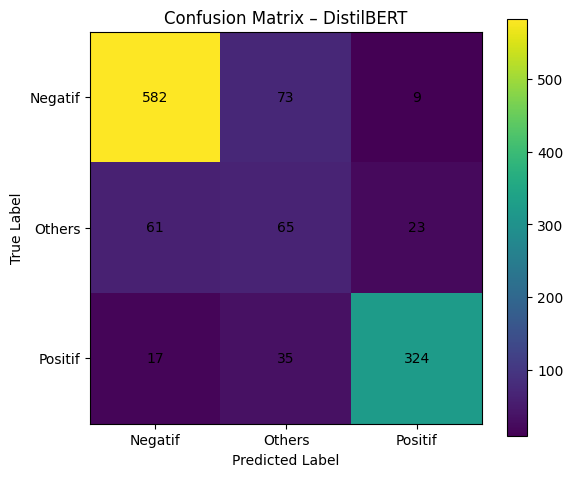

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1️⃣ Prediksi ulang (WAJIB ada di cell yang sama)
preds_lite = trainer_lite.predict(test_dataset_lite)

# 2️⃣ Ambil logits dengan aman (FIX utama)
logits_lite = preds_lite.predictions
if isinstance(logits_lite, tuple):
    logits_lite = logits_lite[0]

# 3️⃣ Hitung label prediksi
y_pred_lite = np.argmax(logits_lite, axis=1)

# 4️⃣ Confusion Matrix
cm_lite = confusion_matrix(y_test, y_pred_lite)

labels = label_encoder.classes_
x = np.arange(len(labels))

plt.figure(figsize=(6,5))
plt.imshow(cm_lite)
plt.colorbar()

plt.xticks(x, labels)
plt.yticks(x, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm_lite[i, j], ha="center", va="center")

plt.title("Confusion Matrix – DistilBERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

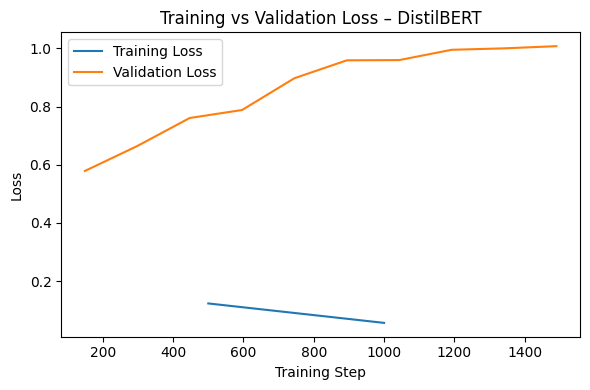

In [ ]:
log_history_lite = pd.DataFrame(trainer_lite.state.log_history)

train_loss_lite = log_history_lite[log_history_lite["loss"].notna()]
eval_loss_lite  = log_history_lite[log_history_lite["eval_loss"].notna()]

plt.figure(figsize=(6,4))
plt.plot(train_loss_lite["step"], train_loss_lite["loss"], label="Training Loss")
plt.plot(eval_loss_lite["step"], eval_loss_lite["eval_loss"], label="Validation Loss")

plt.title("Training vs Validation Loss – DistilBERT")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Path DistilBERT
distilbert_path = f"{base_path}/distilbert"

# Simpan model & tokenizer
trainer_lite.model.save_pretrained(distilbert_path)
trainer_lite.tokenizer.save_pretrained(distilbert_path)

print(f"✅ DistilBERT berhasil disimpan di:\n{distilbert_path}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


✅ DistilBERT berhasil disimpan di:
/content/drive/MyDrive/Praktikum/UAP/model/distilbert


##PERBANDINGAN MODEL

In [ ]:
def extract_metrics(y_true, y_pred):
    report = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Macro)": report["macro avg"]["precision"],
        "Recall (Macro)": report["macro avg"]["recall"],
        "F1-score (Macro)": report["macro avg"]["f1-score"]
    }
    return metrics

In [ ]:
# ===== LSTM =====
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)

metrics_lstm = extract_metrics(y_test, y_pred_lstm)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# ===== INDO BERT =====
preds_indobert = trainer.predict(test_dataset)

logits_indobert = preds_indobert.predictions
if isinstance(logits_indobert, tuple):
    logits_indobert = logits_indobert[0]

y_pred_indobert = np.argmax(logits_indobert, axis=1)

metrics_indobert = extract_metrics(y_test, y_pred_indobert)

In [ ]:
# ===== DISTILBERT =====
preds_distilbert = trainer_lite.predict(test_dataset_lite)

logits_distilbert = preds_distilbert.predictions
if isinstance(logits_distilbert, tuple):
    logits_distilbert = logits_distilbert[0]

y_pred_distilbert = np.argmax(logits_distilbert, axis=1)

metrics_distilbert = extract_metrics(y_test, y_pred_distilbert)

In [ ]:
comparison_df = pd.DataFrame.from_dict({
    "LSTM": metrics_lstm,
    "IndoBERT": metrics_indobert,
    "DistilBERT": metrics_distilbert
}, orient="index")

comparison_df

,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro)
LSTM,0.125315,0.041772,0.333333,0.074240
IndoBERT,0.838520,0.746019,0.744800,0.745356
DistilBERT,0.816653,0.722551,0.724817,0.722709


##DASHBOARD

In [ ]:
!pip install streamlit -q
!pip install pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.3 MB/s eta 0:00:00


In [ ]:
code = '''
import streamlit as st
import numpy as np
import joblib
import torch
import re
import pandas as pd


from transformers import AutoTokenizer, AutoModelForSequenceClassification

# =========================
# KONFIGURASI (DRIVE)
# =========================
BASE_PATH = "/content/drive/MyDrive/Praktikum/UAP/model"
ENCODER_PATH = "/content/drive/MyDrive/Praktikum/UAP/encoder"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

st.set_page_config(
    page_title="Sentiment Analysis UAP",
    layout="centered"
)

st.title("Sentiment Analysis Ulasan Game (UAP)")
st.write("Analisis sentimen ulasan game **Clash Royale** Bahasa Indonesia")

# =========================
# LOAD LABEL ENCODER
# =========================
@st.cache_resource
def load_label_encoder():
    return joblib.load(f"{ENCODER_PATH}/label_encoder.pkl")

label_encoder = load_label_encoder()

# =========================
# LOAD MODELS (DI AWAL)
# =========================
@st.cache_resource
def load_indobert_model():
    tokenizer = AutoTokenizer.from_pretrained(f"{BASE_PATH}/indobert")
    model = AutoModelForSequenceClassification.from_pretrained(f"{BASE_PATH}/indobert")
    model.to(DEVICE)
    model.eval()
    return tokenizer, model

@st.cache_resource
def load_distilbert_model():
    tokenizer = AutoTokenizer.from_pretrained(f"{BASE_PATH}/distilbert")
    model = AutoModelForSequenceClassification.from_pretrained(f"{BASE_PATH}/distilbert")
    model.to(DEVICE)
    model.eval()
    return tokenizer, model


# LOAD SEKALI SAAT APP DIBUKA
with st.spinner("Memuat model..."):
    tokenizer_indobert, model_indobert = load_indobert_model()
    tokenizer_distilbert, model_distilbert = load_distilbert_model()

st.success("Model berhasil dimuat")

# =========================
# PREPROCESS TEXT
# =========================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.strip()

# =========================
# UI INPUT
# =========================
model_choice = st.selectbox(
    "Pilih Model",
    ["IndoBERT", "DistilBERT"]
)

user_text = st.text_area(
    "Masukkan Ulasan Game",
    height=120,
    placeholder="Contoh: game ini sangat seru dan grafiknya bagus..."
)

# =========================
# PREDIKSI
# =========================
if st.button("🔍 Prediksi Sentimen"):

    if user_text.strip() == "":
        st.warning("⚠️ Ulasan tidak boleh kosong")
    else:
        clean = clean_text(user_text)

        # PILIH MODEL YANG SUDAH DI-LOAD
        if model_choice == "IndoBERT":
            tokenizer = tokenizer_indobert
            model = model_indobert
        else:
            tokenizer = tokenizer_distilbert
            model = model_distilbert

        inputs = tokenizer(
            clean,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)

        label = label_encoder.inverse_transform([pred_idx])[0]
        confidence = probs[pred_idx] * 100

        # =========================
        # OUTPUT
        # =========================

        st.success(f"**Prediksi Sentimen:** {label}")
        st.info(f"**Confidence:** {confidence:.2f}%")

        # =========================
        # GRAFIK PROBABILITAS
        # =========================
        st.subheader("Grafik Probabilitas Sentimen")

        prob_df = pd.DataFrame({
            "Sentimen": label_encoder.classes_,
            "Probabilitas (%)": probs * 100
        })

        st.bar_chart(
            prob_df.set_index("Sentimen"),
            height=300
        )

        # =========================
        # DETAIL ANGKA
        # =========================
        st.subheader("Probabilitas Detail")
        for i, cls in enumerate(label_encoder.classes_):
            st.write(f"- **{cls}**: {probs[i]*100:.2f}%")


'''

with open("app.py", "w") as f:
    f.write(code)


<>:69: SyntaxWarning: invalid escape sequence '\S'
<>:69: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-3963041013.py:69: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub(r"http\S+", "", text)


In [ ]:
!ngrok config add-authtoken 2yGGl3lN9kjPArxQaN2e8hltsBH_2qufM9zYpsSj9WFWA1mTd

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import threading
import os

# Jalankan Streamlit di thread terpisah
def run():
    os.system('streamlit run app.py')

thread = threading.Thread(target=run)
thread.start()

import time
time.sleep(5)

# Buka tunnel ke Streamlit (gunakan addr bukan port!)
public_url = ngrok.connect(addr="http://localhost:8501")
print("✅ Streamlit tersedia di URL berikut:")
print(public_url)

✅ Streamlit tersedia di URL berikut:
NgrokTunnel: "https://3dd00fdf8be6.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill ngrok